In [3]:
import os
import ase
import torch
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from ase.io import Trajectory
from ase.visualize import view
import nglview as nv
import ipywidgets
from ase.neighborlist import natural_cutoffs, NeighborList
from fairchem.core.datasets import LmdbDataset
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pylab as pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scienceplots
from math import floor, log10
from matplotlib import rc
plt.style.use(['science','no-latex'])

params = {'figure.dpi': 900,
            'axes.labelsize': 'small',
          'legend.fontsize': 'x-small',
         'axes.titlesize':'medium',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.family': 'DejaVu Sans'}

pylab.rcParams.update(params)


checkpoint_dir = "/data/shared/ishan_stuff/student_checkpoints/spice"

# nv.show_asetraj(traj)


In [28]:
def distance_pbc(x0, x1, lattices):
    delta = torch.abs(x0 - x1)
    lattices = lattices.view(-1,1,3)
    delta = torch.where(delta > 0.5 * lattices, delta - lattices, delta)
    return torch.sqrt((delta ** 2).sum(dim=-1))

def dir_to_legend_name(md_dir):
    name = ""
    if "gem" in md_dir.lower():
        name += "GemNet-dT "
    elif "painn" in md_dir.lower():
        name += "PaiNN "
    
    if "dist" in md_dir.lower():
        name += "Distilled"
    else:
        name += "Undistilled"
    return name

def get_thermo(filename):
    """
    read thermo logs.
    """
    with open(filename, 'r') as f:
        thermo = f.read().splitlines()
        sim_time, Et, Ep, Ek, T = [], [], [], [], []
        for i in range(1, len(thermo)):
            try:
                t, Etot, Epot, Ekin, Temp = [float(x) for x in thermo[i].split(' ') if x]
                sim_time.append(t)
                Et.append(Etot)
                Ep.append(Epot)
                Ek.append(Ekin)
                T.append(Temp)
            except:
                sim_time, Et, Ep, Ek, T = [], [], [], [], []
    thermo = {
        'time': sim_time,
        'Et': Et,
        'Ep': Ep,
        'Ek': Ek,
        'T': T
    }
    return thermo

def plot_stability(md_dirs):
    plt.figure()
    plt.xlabel("Simulation time (picoseconds)")
    plt.ylabel("Maximum bond length deviation (A)")
    plt.axhline(stability_threshold, c = 'r', label = "Stability Threshold")
    plt.yscale('log')

    for i, md_dir in enumerate(md_dirs):
        traj = Trajectory(os.path.join(checkpoint_dir, md_dir, "equilibration10.traj"))
        # get bonds from simulated trajectory
        if i == 0:
            atoms = traj[0]
            NL = NeighborList(natural_cutoffs(deepcopy(atoms)), self_interaction=False)
            NL.update(atoms)
            bonds = NL.get_connectivity_matrix().todense().nonzero()
            bonds = torch.tensor(bonds)


            # get bonds from GT trajectory
            data = LmdbDataset({"src": "/data/shared/ishan_stuff/spice_separated/Solvated_Amino_Acids/train"})

            gt_traj = []
            for idx in range(len(data)):
                dat = data.__getitem__(idx)
                if dat.atomic_numbers.shape[0] == atoms.numbers.shape[0]:
                    if np.equal(np.array(dat.atomic_numbers), atoms.numbers).all():
                        gt_traj.append(dat.pos)

            gt_traj = torch.stack(gt_traj)

            bond_lens = distance_pbc(
                gt_traj[:, bonds[0]], gt_traj[:, bonds[1]], torch.FloatTensor([30., 30., 30.]))
            mean_bond_lens = bond_lens.mean(dim=0)

            # remove bonds larger than 5 A
            bonds = bonds[:, mean_bond_lens < 5]
            mean_bond_lens = mean_bond_lens[mean_bond_lens < 5]
                    

        run = {}

        # process trajectory
        traj = [x.positions for x in traj]
        run['traj'] = torch.from_numpy(np.stack(traj))

        # load thermo log
        run['thermo'] = get_thermo(os.path.join(checkpoint_dir, md_dir, "md_system10.log"))
        T = np.array(run['thermo']['T']) 
        collapse_pt = len(T)
        md_time = np.array(run['thermo']['time'])
        
        subsample = int(len(traj) / collapse_pt)
        run['traj'] = run['traj'][::subsample]
        # track stability

        devs = []
        for i in tqdm(range(1, len(T))):
            bond_lens = distance_pbc(
                run['traj'][(i-1):i, bonds[0]], run['traj'][(i-1):i, bonds[1]], torch.FloatTensor([30., 30., 30.]))
            max_dev = (bond_lens[0] - mean_bond_lens).abs().max()
            devs.append(max_dev)
            if  max_dev > stability_threshold:
                collapse_pt = i
                break
        run['collapse_pt'] = collapse_pt
        run['devs'] = devs

        plt.plot(run['devs'], label = dir_to_legend_name(md_dir))
    plt.legend(frameon=True, edgecolor='black')
    
    plt.savefig("stability.png")
    plt.show()
    plt.close()


100%|██████████| 100/100 [00:00<00:00, 12491.97it/s]


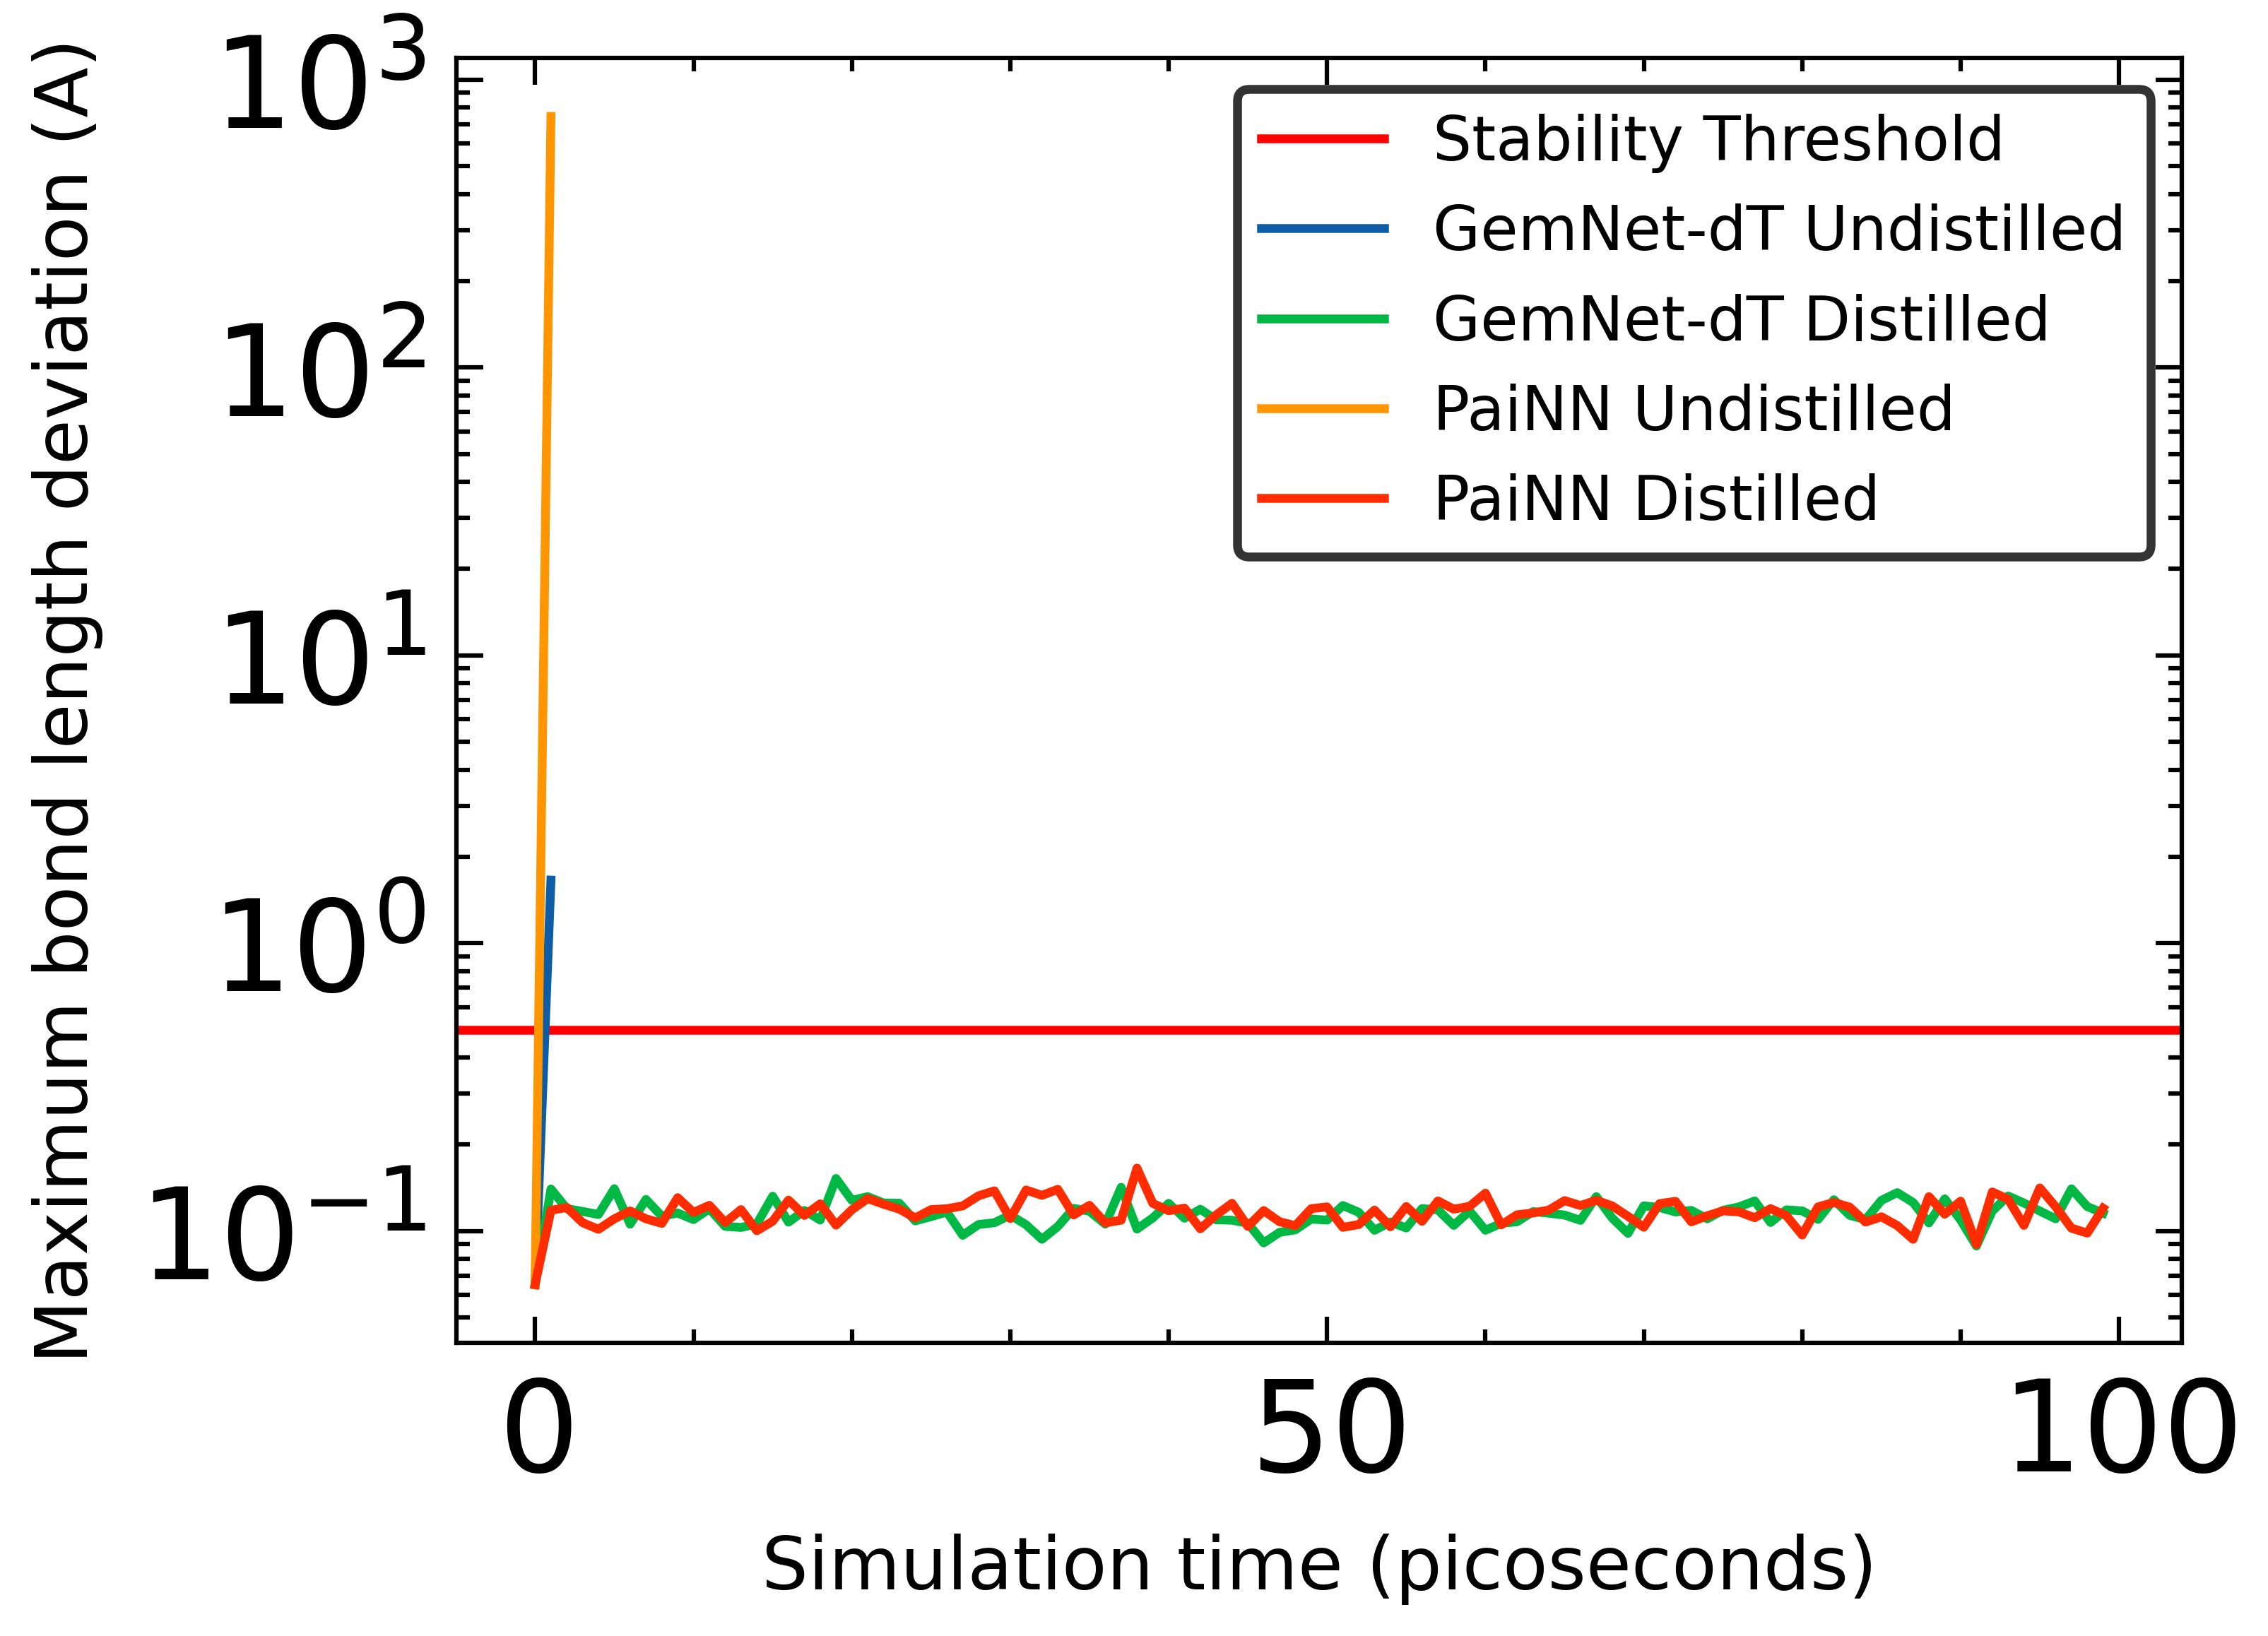

In [29]:
# Basic stability check on the trajectory (based on bond length deviations)
stability_threshold = 0.5
md_dirs = ["2024-09-05-09-42-40-amino-gemSmall", "2024-09-05-13-45-52-solvated-gemSmall-DIST-4s", "2024-09-15-12-44-00-solvated_PaiNNpbc", "2024-09-15-14-45-36-solvated-Painn-DIST-pbc"]
plot_stability(md_dirs)